<a href="https://colab.research.google.com/github/kevlord997/ML_Algorithmic_Trading_Projects/blob/lesson-7/ML_Trading_L7_Regression_and_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. INSTALLATION: We need imbalanced-learn for SMOTE
!pip install yfinance pandas ta scikit-learn imbalanced-learn --quiet

# 2. IMPORTS: Grouping related tools
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestClassifier # Our new model!
from imblearn.over_sampling import SMOTE # Our imbalance fix!
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# 3. DATA RETRIEVAL (Review): Downloading the time series data
ticker = "SPY"
spy_data = yf.download(ticker, start="2010-01-01", end="2024-01-01")
spy_data.columns = spy_data.columns.get_level_values(0)
spy_data.rename(columns={'Close': 'Adj Close'}, inplace=True)

  Preparing metadata (setup.py) ... done


/tmp/ipython-input-4039270284.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download(ticker, start="2010-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [5]:
# Assuming you have the data download/cleanup from Lesson 6

# 1. New Target: Percentage Return
N = 5 # Look-ahead days
spy_data['Future_Return'] = spy_data['Adj Close'].pct_change(N).shift(-N) * 100

# 2. Re-create all features (X) including the binary signal
spy_data['SMA_20'] = spy_data['Adj Close'].rolling(window=20).mean()
spy_data['SMA_100'] = spy_data['Adj Close'].rolling(window=100).mean()

# RSI is one of the most critical trading indicators.
rsi_indicator = RSIIndicator(close=spy_data['Adj Close'], window=14)
spy_data['RSI'] = rsi_indicator.rsi()

# Momentum (Directly measures price change over N periods)
spy_data['MOM'] = spy_data['Adj Close'].diff(periods=10)

# ... (Recalculate SMA_100, RSI, MOM) ...
spy_data['SMA_Cross_Signal'] = np.where(spy_data['SMA_20'] > spy_data['SMA_100'], 1, 0)
spy_data.dropna(inplace=True)

# Define X and Y (The Continuous Return)
X = spy_data[['SMA_20', 'SMA_100', 'RSI', 'MOM', 'SMA_Cross_Signal']]
Y = spy_data['Future_Return']

# 80/20 chronological split and scaling (re-use Lesson 6 code)
# ... (X_train_scaled, X_test_scaled, Y_train, Y_test) ...

In [6]:
# 6. TIME SERIES SPLIT (Deep Dive): Maintaining chronological order
split_point = int(len(X) * 0.8)

# Why use slicing ([:split_point]) instead of train_test_split(..., shuffle=True)?
# (Answer: To prevent data leakage. Shuffling a time series allows the model to "see" the future when training, leading to artificially inflated, useless accuracy.)
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

# 7. FEATURE SCALING (Deep Dive): Standardizing the feature ranges
scaler = StandardScaler()
# Why fit_transform on train, but only transform on test?
# (Answer: The model must learn the standard deviation and mean *only* from the training data. Applying the transform to the test set ensures the test data is treated as 'new, unseen' data, preventing information leakage.)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Train the Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, Y_train)

# 2. Make predictions on the test set
# Y_pred is now a continuous percentage return (e.g., 0.5 for +0.5% return)
Y_pred = lr_model.predict(X_test_scaled)

# 3. Evaluate with Regression Metric: Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, Y_pred)

print(f"\n--- Linear Regression Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# MSE is hard to interpret; lower is better. It measures the average squared prediction error.


--- Linear Regression Evaluation ---
Mean Squared Error (MSE): 6.5151


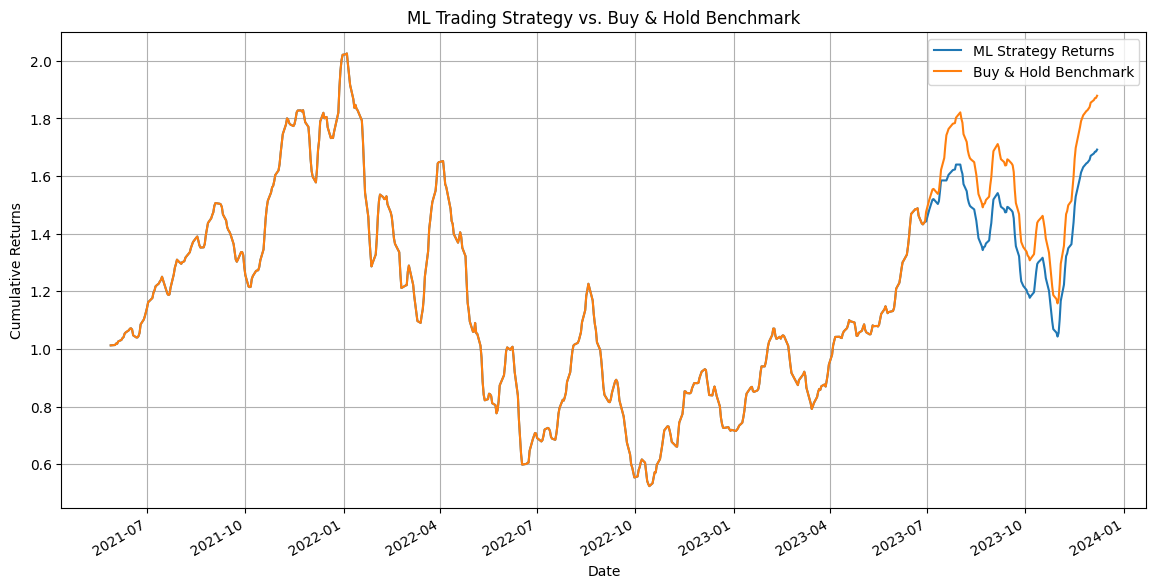

In [9]:
import matplotlib.pyplot as plt

# 1. Create a DataFrame for Backtesting
test_df = spy_data.iloc[split_point:].copy() # Use the non-scaled data for price reference
test_df['Predicted_Return'] = Y_pred

# 2. Create the Trading Signal
# Signal: +1 (Buy) if predicted return > 0, 0 (Cash/Sell) otherwise.
test_df['Signal'] = np.where(test_df['Predicted_Return'] > 0, 1, 0)

# 3. Calculate Daily Returns based on the Signal
# When Signal is 1, our return is the actual *Future_Return* (since we bought N days ago)
# We need to shift the actual return back N days to align with the Signal creation date
test_df['Strategy_Return'] = test_df['Future_Return'].shift(N) * test_df['Signal'] / 100

# 4. Calculate Cumulative Returns
# Note: We divide by 100 in step 3 because Future_Return is a percentage (e.g., 5.0)
test_df['Cumulative_Strategy_Returns'] = (1 + test_df['Strategy_Return']).cumprod()
test_df['Cumulative_Benchmark_Returns'] = (1 + (test_df['Future_Return'].shift(N)/100)).cumprod()

# 5. Plot the Backtest Results
plt.figure(figsize=(14, 7))
test_df['Cumulative_Strategy_Returns'].plot(label='ML Strategy Returns')
test_df['Cumulative_Benchmark_Returns'].plot(label='Buy & Hold Benchmark')
plt.title('ML Trading Strategy vs. Buy & Hold Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Displaying the Coefficients (Weights)
coefficients = pd.Series(lr_model.coef_, index=X.columns)
print("\nLinear Regression Coefficients:")
print(coefficients.sort_values(ascending=False))


Linear Regression Coefficients:
Price
SMA_100             1.064058
MOM                 0.124818
SMA_Cross_Signal   -0.178728
RSI                -0.231343
SMA_20             -1.011623
dtype: float64


In [13]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 6.5151
